In [1]:
versioninfo()


Julia Version 1.12.4
Commit 01a2eadb04 (2026-01-06 16:56 UTC)
Build Info:

    Note: This is an unofficial build, please report bugs to the project
    responsible for this build and not to the Julia project unless you can
    reproduce the issue using official builds available at https://julialang.org

Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: 16 × AMD Ryzen 7 7800X3D 8-Core Processor
  WORD_SIZE: 64
  LLVM: libLLVM-18.1.7 (ORCJIT, znver4)
  GC: Built with stock GC
Threads: 16 default, 1 interactive, 16 GC (on 16 virtual cores)
Environment:
  JULIA_NUM_THREADS = 16


In [2]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()
Base.active_project()
Threads.nthreads()


  Activating project at `~/Dokumente/BA2/notebooks/data_generation`


16

In [3]:
Threads.nthreads()


16

In [4]:
include("erpgen.jl")
using .ERPGen
ERPGen.ensure_latest_unfoldsim!()


    Updating registry at `~/.julia/registries/General.toml`


Progress: 1/1 reps (per class=1, total images=28)
Meta: (pattern = :sigmoid, variant = :normal, trial_order = :normal, inverted = false, mu = 3.134967309351503, sigma = 0.45871458676593535, epoch_duration_s = 1.020714699048481, sampling_rate = 353, crop_start_ms = 2, crop_end_ms = 6, crop_start_samples = 1, crop_end_samples = 2, dropout_trials_rate = 41, dropout_trials = 41, erpimage_raw_size = (8192, 361), erpimage_processed_size = (8151, 358), condition_levels = 8, noise = ["PinkNoise", "WhiteNoise", "RedNoise", "ExponentialNoise"], noiselevels = Dict(:WhiteNoise => 1.0692127891514172, :RedNoise => 0.9453175867585896, :ExponentialNoise => 0.9684580424996168, :PinkNoise => 0.9945420390184343), p1_beta = 3.9728936682178624, p3_beta = 4.059853065401212, n1_betas = (5.506454492362232, 3.9611549300016224, 1.5886806736346735), p100_width = 0.021154623290127638, p100_offset = 0.09660868087716466, p300_width = 0.0028328611898017, p300_offset = 0.3717739466590313, n170_width = 0.0028328611898

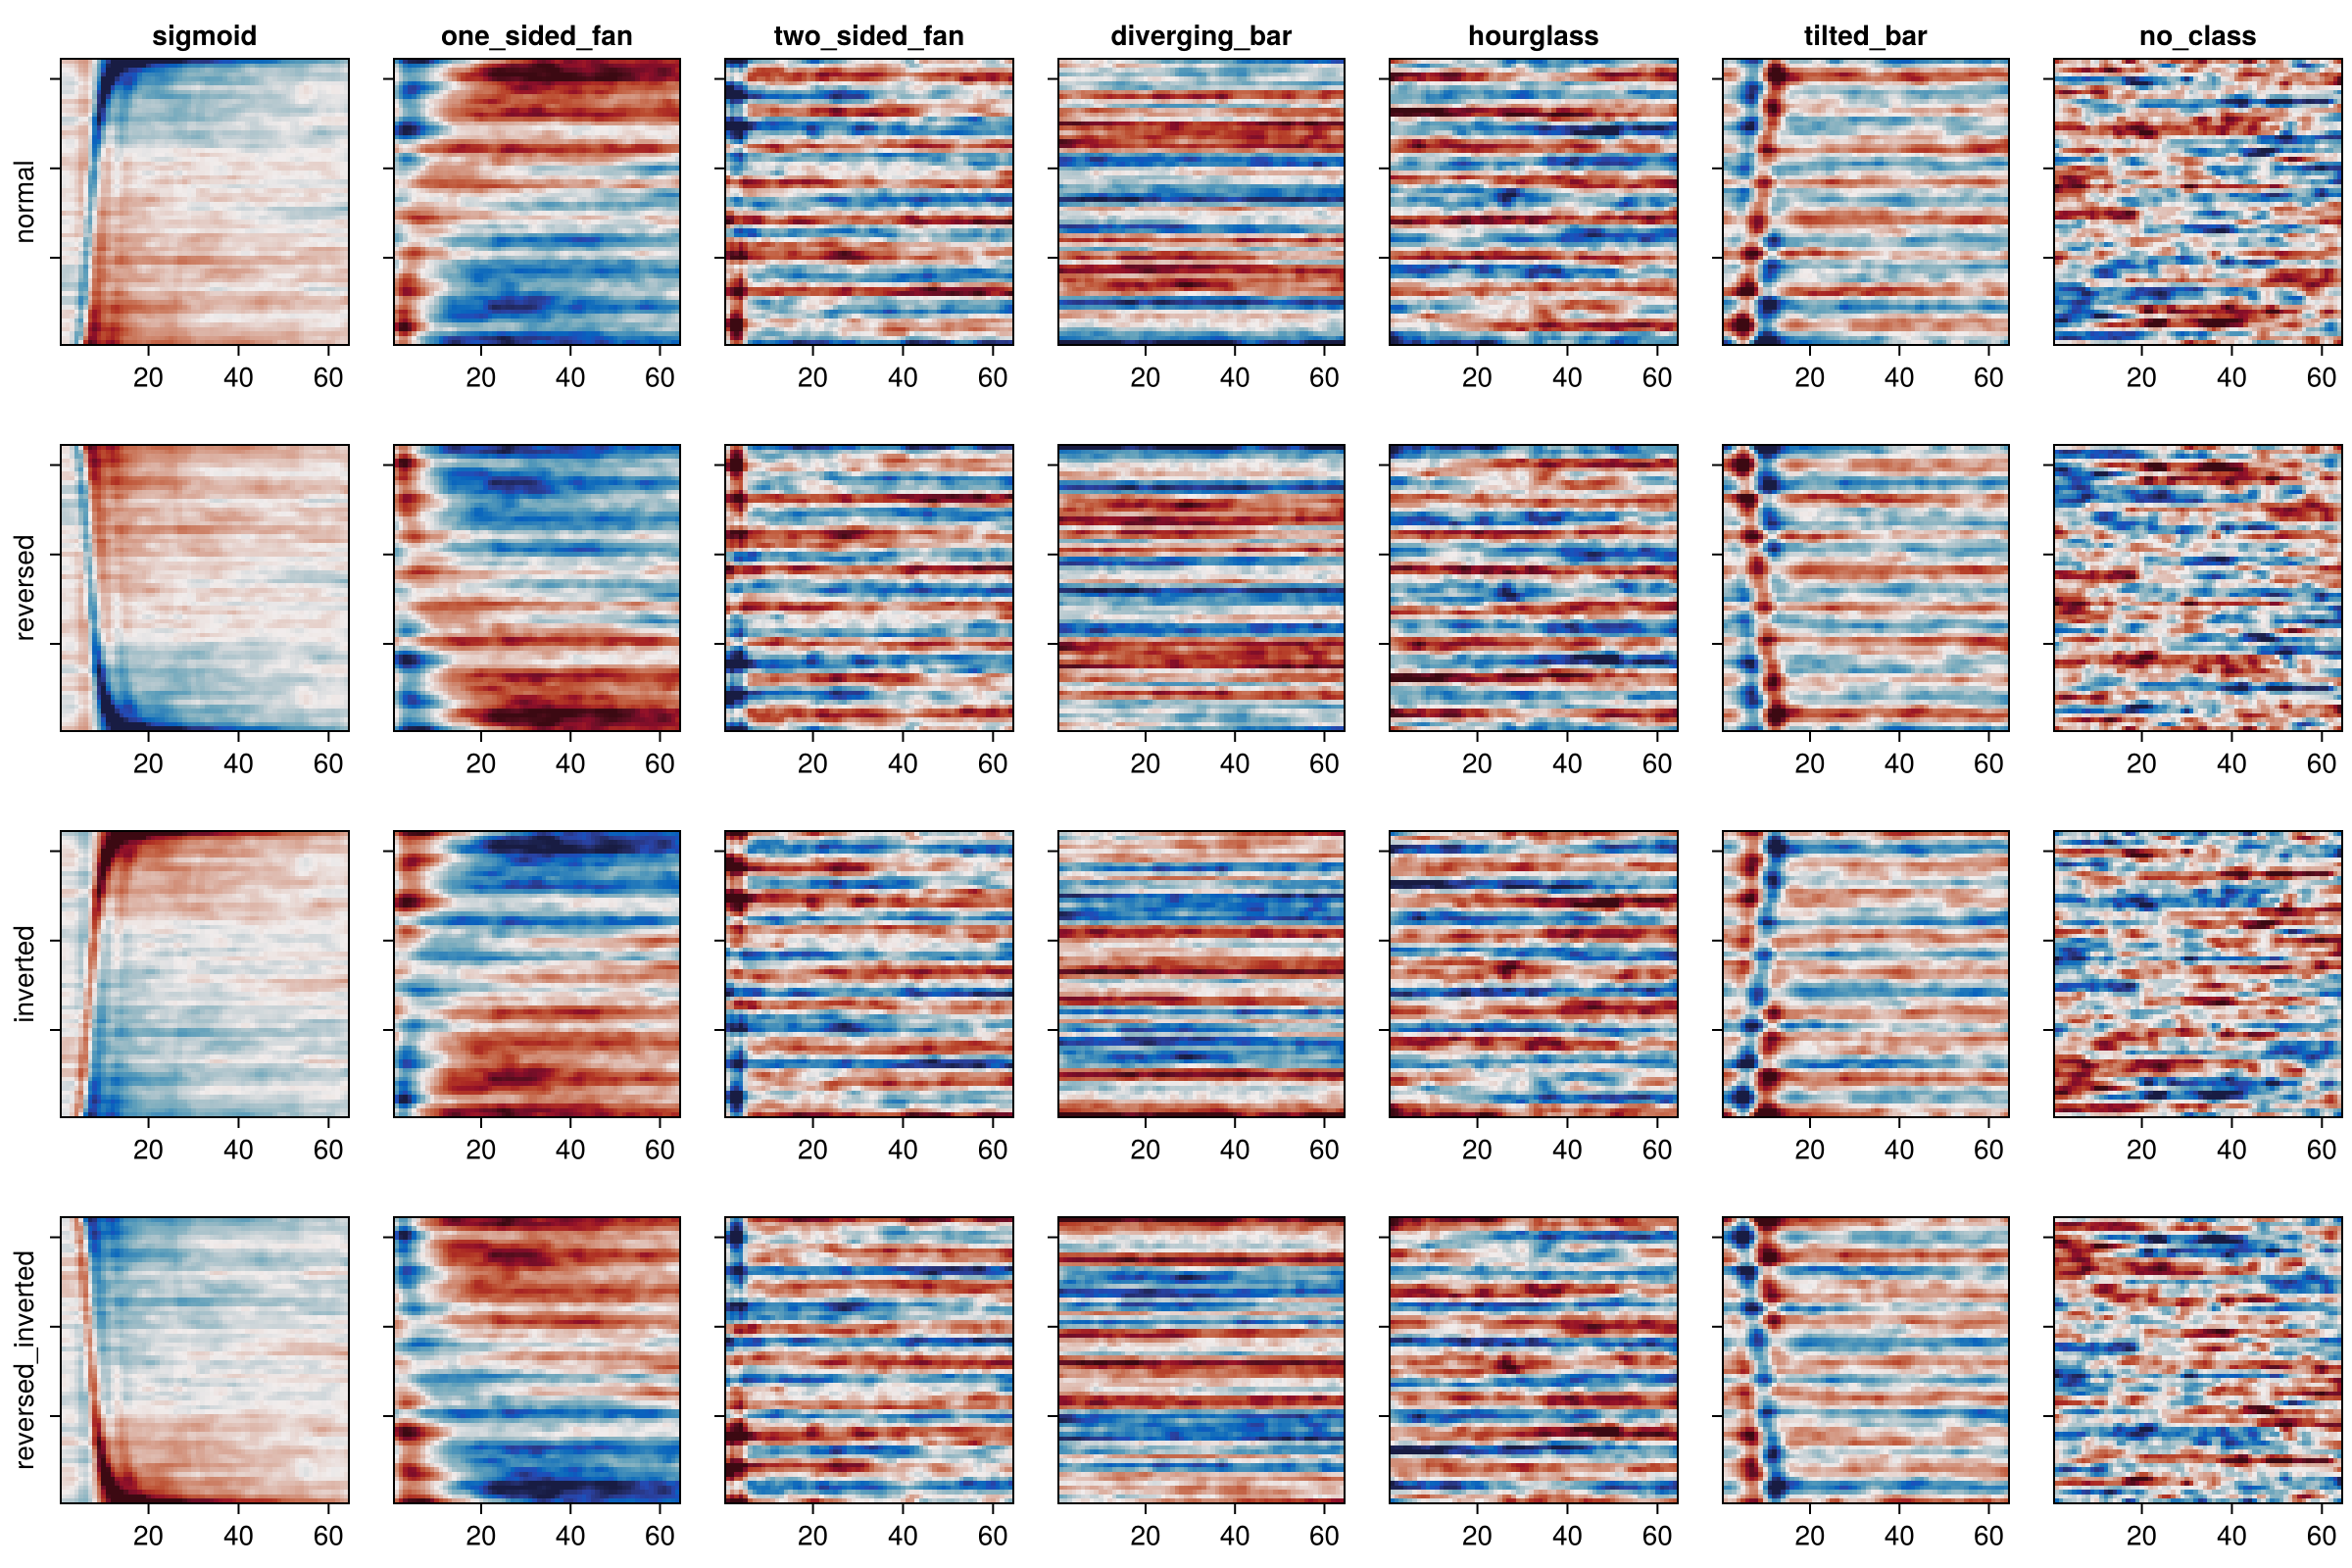

In [5]:
# Overview

using Distributions: Normal, DiscreteUniform
using Statistics: quantile
using Interpolations
using UnfoldSim: PinkNoise, WhiteNoise, RedNoise, ExponentialNoise


mu_dist = Normal(3.2, 0.1)
sigma_dist = Normal(0.5, 0.05)
condition_levels_dist = DiscreteUniform(8, 8)

# P1 component distributions
p1_beta_dist = Normal(5.0, 1.0)

# P3 component distribution
p3_beta_dist = Normal(5.0, 0.75)

# Hanning basis distributions
p100_width_dist = Normal(0.01, 0.015)
p100_offset_dist = Normal(0.1, 0.015)
p300_width_dist = Normal(0.03, 0.045)
p300_offset_dist = Normal(0.3, 0.045)
n170_width_dist = Normal(0.015, 0.0225)
n170_offset_dist = Normal(0.17, 0.0255)

# N1 component distributions
n1_beta1_dist = Normal(5.0, 0.75)
n1_beta2_dist = Normal(3.0, 0.45)
n1_beta3_dist = Normal(2.0, 0.3)
componentA_amp_dist = Normal(5.0, 1.0)
componentB_amp_dist = Normal(-10.0, 1.0)
componentC_amp_dist = Normal(5.0, 1.0)

one_sided_fan_duration_start_dist = Normal(20.0, 0.2)
one_sided_fan_duration_end_dist = Normal(100.0, 0.5)
two_sided_fan_duration_start_dist = Normal(10.0, 0.2)
two_sided_fan_duration_end_dist = Normal(30.0, 0.5)
tilted_bar_duration_start_dist = Normal(5.0, 0.1)
tilted_bar_duration_end_dist = Normal(40.0, 0.5)
hourglass_continuous_start_dist = Normal(-2.0, 0.05)
hourglass_continuous_end_dist = Normal(2.0, 0.05)


sampling_rate_dist = Normal(350.0, 5.0)
epoch_duration_dist = Normal(1.0, 0.05)

dropout_trials_rate_dist = Normal(50.0, 10.0)

crop_start_dist = Normal(0.0, 5.0)
crop_end_dist = Normal(0.0, 5.0)

noiselevel_dists = Dict(
    PinkNoise => Normal(1, 0.05),
    WhiteNoise => Normal(1, 0.05),
    RedNoise => Normal(1, 0.05),
    ExponentialNoise => Normal(1, 0.05),
)

noise_pool = ERPGen.DEFAULT_NOISE_POOL

zscore_timepoints = true
filter_sigma = 1.0
gauss_smooth = false
gauss_kernel_len = 20
resize_antialias = true  # low-pass prefilter before resize
antialias_factor = 0.75
resize_method = Interpolations.Linear()

target_height = 64
target_width = 64

# Threading / progress
threaded = false
blas_threads = 1
progress_every = 10

images, labels, metadata = ERPGen.generate_erp_images(
    n_per_pattern = 1,
    mu_dist = mu_dist,
    sigma_dist = sigma_dist,
    sampling_rate_dist = sampling_rate_dist,
    dropout_trials_rate_dist = dropout_trials_rate_dist,
    epoch_duration_dist = epoch_duration_dist,
    condition_levels_dist = condition_levels_dist,
    p1_beta_dist = p1_beta_dist,
    p3_beta_dist = p3_beta_dist,
    p100_width_dist = p100_width_dist,
    p100_offset_dist = p100_offset_dist,
    p300_width_dist = p300_width_dist,
    p300_offset_dist = p300_offset_dist,
    n170_width_dist = n170_width_dist,
    n170_offset_dist = n170_offset_dist,
    n1_beta1_dist = n1_beta1_dist,
    n1_beta2_dist = n1_beta2_dist,
    n1_beta3_dist = n1_beta3_dist,
    componentA_amp_dist = componentA_amp_dist,
    componentB_amp_dist = componentB_amp_dist,
    componentC_amp_dist = componentC_amp_dist,
    one_sided_fan_duration_start_dist = one_sided_fan_duration_start_dist,
    one_sided_fan_duration_end_dist = one_sided_fan_duration_end_dist,
    two_sided_fan_duration_start_dist = two_sided_fan_duration_start_dist,
    two_sided_fan_duration_end_dist = two_sided_fan_duration_end_dist,
    tilted_bar_duration_start_dist = tilted_bar_duration_start_dist,
    tilted_bar_duration_end_dist = tilted_bar_duration_end_dist,
    hourglass_continuous_start_dist = hourglass_continuous_start_dist,
    hourglass_continuous_end_dist = hourglass_continuous_end_dist,
    target_height = target_height,
    target_width = target_width,
    zscore_timepoints = zscore_timepoints,
    filter_sigma = filter_sigma,
    gauss_smooth = gauss_smooth,
    gauss_kernel_len = gauss_kernel_len,
    resize_antialias = resize_antialias,
    antialias_factor = antialias_factor,
    resize_method = resize_method,
    noise_pool = noise_pool,
    noiselevel_dists = noiselevel_dists,
    crop_start_dist = crop_start_dist,
    crop_end_dist = crop_end_dist,
    threaded = threaded,
    blas_threads = blas_threads,
    progress_every = progress_every,
)

using CairoMakie

label_to_idx = Dict{Tuple{Symbol, Symbol}, Int}()
for (i, meta) in enumerate(metadata)
    key = (meta.pattern, meta.variant)
    if !haskey(label_to_idx, key)
        label_to_idx[key] = i
    end
end

pattern_names = ERPGen.PATTERN_NAMES
variant_names = ERPGen.VARIANT_NAMES

ncols = length(pattern_names)
nrows = length(variant_names)
fig = Figure(size = (1200, 800), figure_padding = 5)
rowgap!(fig.layout, 8)
colgap!(fig.layout, 8)

first_idx = nothing
for (col, pname) in enumerate(pattern_names)
    for (row, vname) in enumerate(variant_names)
        idx = get(label_to_idx, (pname, vname), nothing)
        idx === nothing && continue

        img = images[idx]
        first_idx === nothing && (first_idx = idx)

        title = row == 1 ? string(pname) : ""
        ylabel = col == 1 ? string(vname) : ""
        ax = Axis(fig[row, col];
            title = title,
            ylabel = ylabel,
            xlabelvisible = row == nrows,
            ylabelvisible = col == 1,
            yticklabelsvisible = false,
            aspect = AxisAspect(1),
        )
        vmax = max(quantile(vec(abs.(img)), 0.99), eps(eltype(img)))
        cr = (-vmax, vmax)
        heatmap!(ax, permutedims(img, (2, 1)); colormap = :balance, colorrange = cr)
    end
end

if first_idx !== nothing
    println("Meta: ", metadata[first_idx])
end

fig


Progress: 1/1 reps (per class=1, total images=28)
Meta: (pattern = :sigmoid, variant = :normal, trial_order = :normal, inverted = false, mu = 3.395465756253624, sigma = 0.48339756271680684, epoch_duration_s = 0.960369067839079, sampling_rate = 346, crop_start_ms = 0, crop_end_ms = 248, crop_start_samples = 0, crop_end_samples = 86, dropout_trials_rate = 64, dropout_trials = 64, erpimage_raw_size = (8192, 333), erpimage_processed_size = (8128, 247), condition_levels = 8, noise = ["PinkNoise", "WhiteNoise", "RedNoise", "ExponentialNoise"], noiselevels = Dict(:WhiteNoise => 1.020555841365182, :RedNoise => 0.9077905929279856, :ExponentialNoise => 0.9903425904804924, :PinkNoise => 1.0104410960509065), p1_beta = 5.173838620642361, p3_beta = 5.3903313347241815, n1_betas = (3.52087866712027, 2.5674806421135177, 1.9714730002284948), p100_width = 0.002890173410404624, p100_offset = 0.07612735673705547, p300_width = 0.02040790321986458, p300_offset = 0.32286624919833257, n170_width = 0.0183403336

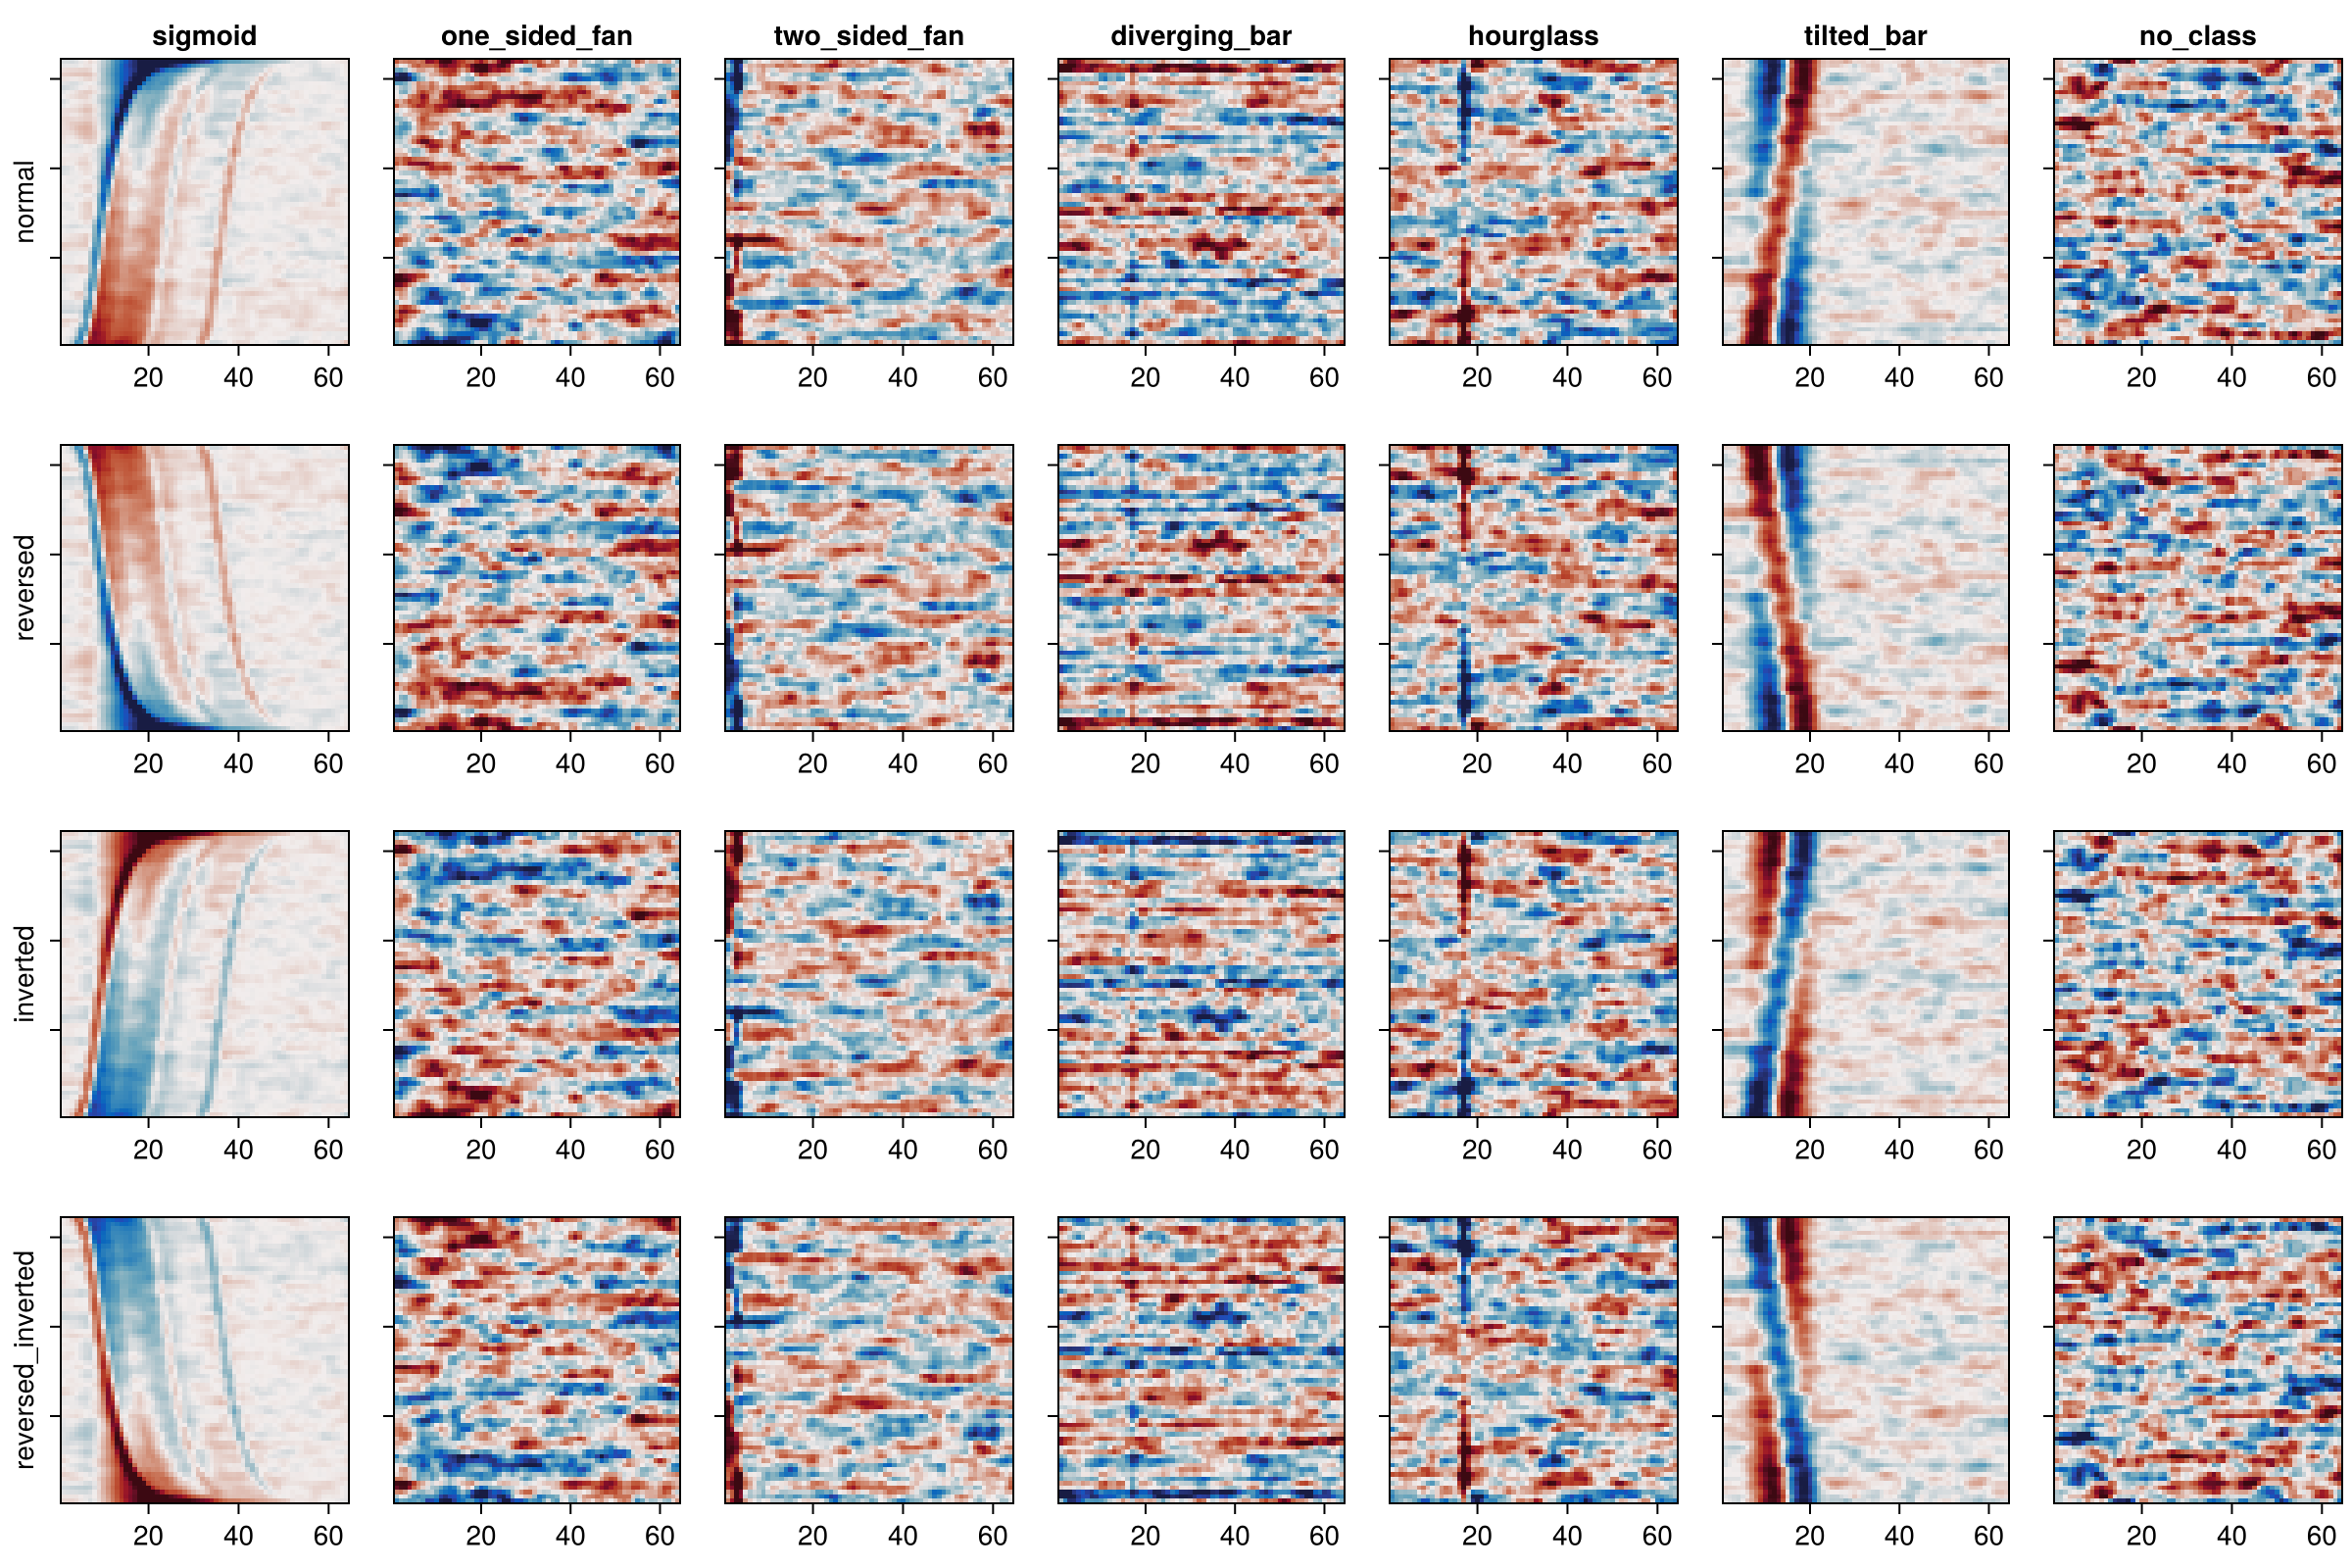

In [8]:
# Test

using Distributions: Normal, DiscreteUniform
using Statistics: quantile
using Interpolations
using UnfoldSim: PinkNoise, WhiteNoise, RedNoise, ExponentialNoise


mu_dist = Normal(3.2, 0.1)
sigma_dist = Normal(0.5, 0.05)
condition_levels_dist = DiscreteUniform(6, 8)

# P1 component distributions
p1_beta_dist = Normal(5.0, 1.0)

# P3 component distribution
p3_beta_dist = Normal(5.0, 0.75)

# Hanning basis distributions
p100_width_dist = Normal(0.01, 0.015)
p100_offset_dist = Normal(0.1, 0.015)
p300_width_dist = Normal(0.03, 0.045)
p300_offset_dist = Normal(0.3, 0.045)
n170_width_dist = Normal(0.015, 0.0225)
n170_offset_dist = Normal(0.17, 0.0255)

# N1 component distributions
n1_beta1_dist = Normal(5.0, 0.75)
n1_beta2_dist = Normal(3.0, 0.45)
n1_beta3_dist = Normal(2.0, 0.3)
componentA_amp_dist = Normal(5.0, 1.0)
componentB_amp_dist = Normal(-10.0, 1.0)
componentC_amp_dist = Normal(5.0, 1.0)

one_sided_fan_duration_start_dist = Normal(20.0, 0.2)
one_sided_fan_duration_end_dist = Normal(10.0, 0.5)
two_sided_fan_duration_start_dist = Normal(10.0, 0.2)
two_sided_fan_duration_end_dist = Normal(15.0, 0.5)
tilted_bar_duration_start_dist = Normal(10.0, 0.1)
tilted_bar_duration_end_dist = Normal(40.0, 0.5)
hourglass_continuous_start_dist = Normal(-2.0, 0.05)
hourglass_continuous_end_dist = Normal(2.0, 0.05)


sampling_rate_dist = Normal(350.0, 5.0)
epoch_duration_dist = Normal(1.0, 0.05)

dropout_trials_rate_dist = Normal(50.0, 10.0)

crop_start_dist = Normal(0.0, 5.0)
crop_end_dist = Normal(200.0, 50.0)

noiselevel_dists = Dict(
    PinkNoise => Normal(1, 0.05),
    WhiteNoise => Normal(1, 0.05),
    RedNoise => Normal(1, 0.05),
    ExponentialNoise => Normal(1, 0.05),
)

noise_pool = ERPGen.DEFAULT_NOISE_POOL

zscore_timepoints = true
filter_sigma = 1.0
gauss_smooth = false
gauss_kernel_len = 20
resize_antialias = true  # low-pass prefilter before resize
antialias_factor = 0.75
resize_method = Interpolations.Linear()

target_height = 64
target_width = 64

# Threading / progress
threaded = false
blas_threads = 1
progress_every = 10

images, labels, metadata = ERPGen.generate_erp_images(
    n_per_pattern = 1,
    mu_dist = mu_dist,
    sigma_dist = sigma_dist,
    sampling_rate_dist = sampling_rate_dist,
    dropout_trials_rate_dist = dropout_trials_rate_dist,
    epoch_duration_dist = epoch_duration_dist,
    condition_levels_dist = condition_levels_dist,
    p1_beta_dist = p1_beta_dist,
    p3_beta_dist = p3_beta_dist,
    p100_width_dist = p100_width_dist,
    p100_offset_dist = p100_offset_dist,
    p300_width_dist = p300_width_dist,
    p300_offset_dist = p300_offset_dist,
    n170_width_dist = n170_width_dist,
    n170_offset_dist = n170_offset_dist,
    n1_beta1_dist = n1_beta1_dist,
    n1_beta2_dist = n1_beta2_dist,
    n1_beta3_dist = n1_beta3_dist,
    componentA_amp_dist = componentA_amp_dist,
    componentB_amp_dist = componentB_amp_dist,
    componentC_amp_dist = componentC_amp_dist,
    one_sided_fan_duration_start_dist = one_sided_fan_duration_start_dist,
    one_sided_fan_duration_end_dist = one_sided_fan_duration_end_dist,
    two_sided_fan_duration_start_dist = two_sided_fan_duration_start_dist,
    two_sided_fan_duration_end_dist = two_sided_fan_duration_end_dist,
    tilted_bar_duration_start_dist = tilted_bar_duration_start_dist,
    tilted_bar_duration_end_dist = tilted_bar_duration_end_dist,
    hourglass_continuous_start_dist = hourglass_continuous_start_dist,
    hourglass_continuous_end_dist = hourglass_continuous_end_dist,
    target_height = target_height,
    target_width = target_width,
    zscore_timepoints = zscore_timepoints,
    filter_sigma = filter_sigma,
    gauss_smooth = gauss_smooth,
    gauss_kernel_len = gauss_kernel_len,
    resize_antialias = resize_antialias,
    antialias_factor = antialias_factor,
    resize_method = resize_method,
    noise_pool = noise_pool,
    noiselevel_dists = noiselevel_dists,
    crop_start_dist = crop_start_dist,
    crop_end_dist = crop_end_dist,
    threaded = threaded,
    blas_threads = blas_threads,
    progress_every = progress_every,
)

using CairoMakie

label_to_idx = Dict{Tuple{Symbol, Symbol}, Int}()
for (i, meta) in enumerate(metadata)
    key = (meta.pattern, meta.variant)
    if !haskey(label_to_idx, key)
        label_to_idx[key] = i
    end
end

pattern_names = ERPGen.PATTERN_NAMES
variant_names = ERPGen.VARIANT_NAMES

ncols = length(pattern_names)
nrows = length(variant_names)
fig = Figure(size = (1200, 800), figure_padding = 5)
rowgap!(fig.layout, 8)
colgap!(fig.layout, 8)

first_idx = nothing
for (col, pname) in enumerate(pattern_names)
    for (row, vname) in enumerate(variant_names)
        idx = get(label_to_idx, (pname, vname), nothing)
        idx === nothing && continue

        img = images[idx]
        first_idx === nothing && (first_idx = idx)

        title = row == 1 ? string(pname) : ""
        ylabel = col == 1 ? string(vname) : ""
        ax = Axis(fig[row, col];
            title = title,
            ylabel = ylabel,
            xlabelvisible = row == nrows,
            ylabelvisible = col == 1,
            yticklabelsvisible = false,
            aspect = AxisAspect(1),
        )
        vmax = max(quantile(vec(abs.(img)), 0.99), eps(eltype(img)))
        cr = (-vmax, vmax)
        heatmap!(ax, permutedims(img, (2, 1)); colormap = :balance, colorrange = cr)
    end
end

if first_idx !== nothing
    println("Meta: ", metadata[first_idx])
end

fig


In [7]:
# # Generation dataset and save as JLD2
# using Random

# if !isdefined(Main, :ERPGen)
#     include("erpgen.jl")
#     using .ERPGen
# end

# println("Threads verfuegbar: ", Threads.nthreads())

# # Save inside the notebooks datasets folder.
# dataset_dir = abspath(joinpath(pwd(), "..", "datasets"))

# rng_seed = time_ns()

# noiselevel_dists = Dict(
#     PinkNoise => Normal(5.0, 2.0),
#     WhiteNoise => Normal(5.0, 2.0),
#     RedNoise => Normal(5.0, 2.0),
#     ExponentialNoise => Normal(5.0, 2.0),
# )

# sampling_rate_dist = Normal(100.0, 5.0)

# dropout_trials_rate_dist = Normal(2000.0, 250.0)
# epoch_duration_dist = Normal(1.0, 0.25)

# crop_start_dist = Normal(100.0, 25.0)
# crop_end_dist = Normal(100.0, 25.0)

# n_per_pattern = 1000
# mu_dist = Normal(3.2, 1.0)
# sigma_dist = Normal(0.5, 0.2)
# condition_levels_dist = DiscreteUniform(8, 8)

# # P1 component distributions
# p1_beta_dist = Normal(5.0, 1.0)
#
# # P3 component distribution
# p3_beta_dist = Normal(5.0, 0.75)
# # Hanning basis distributions
# p100_width_dist = Normal(0.1, 0.015)
# p100_offset_dist = Normal(0.1, 0.015)
# p300_width_dist = Normal(0.3, 0.045)
# p300_offset_dist = Normal(0.3, 0.045)
# n170_width_dist = Normal(0.15, 0.0225)
# n170_offset_dist = Normal(0.17, 0.0255)

# # N1 component distributions
# n1_beta1_dist = Normal(5.0, 0.75)
# n1_beta2_dist = Normal(3.0, 0.45)
# n1_beta3_dist = Normal(2.0, 0.3)

# # Pattern-specific distributions (start/end drawn independently)
# one_sided_fan_duration_start_dist = Normal(20.0, 3.0)
# one_sided_fan_duration_end_dist = Normal(100.0, 15.0)
# two_sided_fan_duration_start_dist = Normal(10.0, 1.5)
# two_sided_fan_duration_end_dist = Normal(30.0, 4.5)
# tilted_bar_duration_start_dist = Normal(5.0, 0.75)
# tilted_bar_duration_end_dist = Normal(40.0, 6.0)
# hourglass_continuous_start_dist = Normal(-2.0, 0.3)
# hourglass_continuous_end_dist = Normal(2.0, 0.3)
# target_height = 64
# target_width = 64
# zscore_timepoints = true
# filter_sigma = 1.0
# gauss_smooth = false
# gauss_kernel_len = 20
# resize_antialias = true  # low-pass prefilter before resize
# antialias_factor = 0.75
# resize_method = Interpolations.Linear()
# noise_pool = ERPGen.DEFAULT_NOISE_POOL
# threaded = true
# blas_threads = 1
# progress_every = 20

# images_big, labels_big, metadata_big = ERPGen.generate_erp_images(
#     n_per_pattern = n_per_pattern,
#     mu_dist = mu_dist,
#     sigma_dist = sigma_dist,
#     sampling_rate_dist = sampling_rate_dist,
#     dropout_trials_rate_dist = dropout_trials_rate_dist,
#     epoch_duration_dist = epoch_duration_dist,
#     condition_levels_dist = condition_levels_dist,
#     p1_beta_dist = p1_beta_dist,
#     p3_beta_dist = p3_beta_dist,
#     p100_width_dist = p100_width_dist,
#     p100_offset_dist = p100_offset_dist,
#     p300_width_dist = p300_width_dist,
#     p300_offset_dist = p300_offset_dist,
#     n170_width_dist = n170_width_dist,
#     n170_offset_dist = n170_offset_dist,
#     p100_width_dist = p100_width_dist,
#     p100_offset_dist = p100_offset_dist,
#     p300_width_dist = p300_width_dist,
#     p300_offset_dist = p300_offset_dist,
#     n170_width_dist = n170_width_dist,
#     n170_offset_dist = n170_offset_dist,
#     n1_beta1_dist = n1_beta1_dist,
#     n1_beta2_dist = n1_beta2_dist,
#     n1_beta3_dist = n1_beta3_dist,
#     componentA_amp_dist = componentA_amp_dist,
#     componentB_amp_dist = componentB_amp_dist,
#     componentC_amp_dist = componentC_amp_dist,
#     one_sided_fan_duration_start_dist = one_sided_fan_duration_start_dist,
#     one_sided_fan_duration_end_dist = one_sided_fan_duration_end_dist,
#     two_sided_fan_duration_start_dist = two_sided_fan_duration_start_dist,
#     two_sided_fan_duration_end_dist = two_sided_fan_duration_end_dist,
#     tilted_bar_duration_start_dist = tilted_bar_duration_start_dist,
#     tilted_bar_duration_end_dist = tilted_bar_duration_end_dist,
#     hourglass_continuous_start_dist = hourglass_continuous_start_dist,
#     hourglass_continuous_end_dist = hourglass_continuous_end_dist,
#     target_height = target_height,
#     target_width = target_width,
#     zscore_timepoints = zscore_timepoints,
#     filter_sigma = filter_sigma,
#     gauss_smooth = gauss_smooth,
#     gauss_kernel_len = gauss_kernel_len,
#     resize_antialias = resize_antialias,
#     antialias_factor = antialias_factor,
#     resize_method = resize_method,
#     noise_pool = noise_pool,
#     noiselevel_dists = noiselevel_dists,
#     crop_start_dist = crop_start_dist,
#     crop_end_dist = crop_end_dist,
#     threaded = threaded,
#     blas_threads = blas_threads,
#     progress_every = progress_every,
# )

# settings = (
#     n_per_pattern = n_per_pattern,
#     mu_dist = mu_dist,
#     sigma_dist = sigma_dist,
#     sampling_rate_dist = sampling_rate_dist,
#     dropout_trials_rate_dist = dropout_trials_rate_dist,
#     epoch_duration_dist = epoch_duration_dist,
#     condition_levels_dist = condition_levels_dist,
#     p1_beta_dist = p1_beta_dist,
#     p100_width_dist = p100_width_dist,
#     p100_offset_dist = p100_offset_dist,
#     p300_width_dist = p300_width_dist,
#     p300_offset_dist = p300_offset_dist,
#     n170_width_dist = n170_width_dist,
#     n170_offset_dist = n170_offset_dist,
#     n1_beta1_dist = n1_beta1_dist,
#     n1_beta2_dist = n1_beta2_dist,
#     n1_beta3_dist = n1_beta3_dist,
#     componentA_amp_dist = componentA_amp_dist,
#     componentB_amp_dist = componentB_amp_dist,
#     componentC_amp_dist = componentC_amp_dist,
#     one_sided_fan_duration_start_dist = one_sided_fan_duration_start_dist,
#     one_sided_fan_duration_end_dist = one_sided_fan_duration_end_dist,
#     two_sided_fan_duration_start_dist = two_sided_fan_duration_start_dist,
#     two_sided_fan_duration_end_dist = two_sided_fan_duration_end_dist,
#     tilted_bar_duration_start_dist = tilted_bar_duration_start_dist,
#     tilted_bar_duration_end_dist = tilted_bar_duration_end_dist,
#     hourglass_continuous_start_dist = hourglass_continuous_start_dist,
#     hourglass_continuous_end_dist = hourglass_continuous_end_dist,
#     target_height = target_height,
#     target_width = target_width,
#     zscore_timepoints = zscore_timepoints,
#     filter_sigma = filter_sigma,
#     gauss_smooth = gauss_smooth,
#     gauss_kernel_len = gauss_kernel_len,
#     resize_antialias = resize_antialias,
#     antialias_factor = antialias_factor,
#     noise_pool = map(x -> string(typeof(x)), noise_pool),
#     noiselevel_dists = noiselevel_dists,
#     crop_start_dist = string(crop_start_dist),
#     crop_end_dist = string(crop_end_dist),
#     threaded = threaded,
#     blas_threads = blas_threads,
#     progress_every = progress_every,
#     rng_seed = rng_seed,
#     pattern_names = ERPGen.PATTERN_NAMES,
#     variant_names = ERPGen.VARIANT_NAMES,
# )

# environment = (
#     julia_version = string(VERSION),
#     nthreads = Threads.nthreads(),
# )

# # Save inside the project datasets folder.
# dataset_dir = abspath(joinpath(pwd(), "..", "..", "datasets"))
# dataset_path = save_erp_dataset(images_big, labels_big, metadata_big;
#     dataset_dir = dataset_dir,
#     prefix = "erp_dataset",
#     settings = settings,
#     environment = environment,
# )

# println("images: ", length(images_big), ", labels: ", length(labels_big), ", metadata: ", length(metadata_big))
# println("Saved to: ", dataset_path)
